In [1]:
import pandas as pd
from numpy import * 
import yfinance as yf
from scipy.stats import norm

#plotting
import matplotlib.pyplot as plt
from tabulate import tabulate


pd.set_option('display.max_rows', 300)


In [20]:
class BS:
    
    def __init__(self, spot, strike, rate, dte, volatility):
        
        #Spot price
        self.spot = spot
        
        #Option strike
        self.strike = strike
        
        #Interest rate
        self.rate = rate
        
        #Days to Expiration (time to maturity, expressed in years)
        self.dte = dte
        
        #Volatility
        self.volatility = volatility
        
        #Utility
        self._a_ = self.volatility * self.dte ** 0.5
        
        if self.strike == 0:
            raise ZeroDivisonError('The strike price cannot be zero')
            
        else:
            self._d1_ = (log(self.spot / self.strike) + \
                        (self.rate+(self.volatility**2) / 2) * self.dte) / self._a_
        self._d2_ = self._d1_ - self._a_
        self._b_ = e**-(self.rate * self.dte)
        
        #The __dict__ attribute
        
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', \
                 'callRho', 'putRho', 'vega', 'gamma']:
            self.__dict__[i] = None
            [self.callPrice, self.putPrice] = self._price()
            [self.callDelta, self.putDelta] = self._delta()
            [self.callTheta, self.putTheta] = self._theta()
            [self.callRho, self.putRho] = self._rho()
            self.vega = self._vega()
            self.gamma = self._gamma()
        
    def _price(self):
        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e**(-self.rate * \
                                                                       self.dte) * norm.cdf(self._d2_)
            put = self.strike * e **(-self.rate * self.dte) * norm.cdf(-self._d2_) - \
                                                                                      self.spot * norm.cdf(-self._d1_)
        return [call,put]
    #Option Delta 
    def _delta(self):
        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if elf.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        return [call, put]
    
    def _gamma(self):
        return norm.pdf(self._d1_) / (self.spot * self._a_)
    
    def _vega(self):
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            #the convention is vega is calculated for one percent jump, that's why we divide it by 100
            return self.spot * norm.pdf(self._d1_) * self.dte ** 0.5 / 100 
    def _theta(self):
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (2*self.dte**0.5) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)
        put = -self.spot * norm.cdf(self._d1_) * self.volatility / (2*self.dte ** .5) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
        return [call / 365, put / 365]
    
    #option rho
    def _rho(self):
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100
        
        return [call, put]
            

In [22]:
#Initialize option 
option = BS(100, 100, 0.05, 1, 0.2)
header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]
print(tabulate(table, header))

  Option Price     Delta     Gamma       Theta     Vega       Rho
--------------  --------  --------  ----------  -------  --------
       10.4506  0.636831  0.018762  -0.0175727  0.37524  0.532325


In [23]:
option.callPrice + option.putPrice

16.024109594442535

In [24]:
option.callDelta + option.putDelta

0.2736613023512382

In [34]:
#straddle helps to focus on volatility and not on the direction

#SPY option
spy = yf.Ticker('SPY')
options = spy.option_chain('2023-07-21')

from datetime import datetime
(datetime(2023,7,21) - datetime.today()).days / 365

0.08767123287671233

In [42]:
spot = 439.46; strike = 440; rate = 0.015; dte = 0.087; vol = 0.14
spy_opt = BS(spot, strike, rate, dte, vol)
print(f'Option Price of SPY230331C00400000 with BS Model is {spy_opt.callPrice:0.4f}')

Option Price of SPY230331C00400000 with BS Model is 7.2558


In [43]:
spy_opt.callDelta, spy_opt.gamma

(0.5089798583576349, 0.02197824516002175)

In [48]:
# Filter calls for strike at or above 400
df = options.calls[options.calls['strike']>=240]
df.reset_index(drop=True, inplace=True)

# Dataframe manipulation with selected fields
df = pd.DataFrame({'Strike': df['strike'], 
                   'Price': df['lastPrice'], 
                   'ImpVol': df['impliedVolatility']})

# Derive greeks and assign to dataframe as columns
df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0.

for i in range(len(df)):
    
    df['Delta'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).callDelta
    df['Gamma'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).gamma
    df['Vega'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).vega
    df['Theta'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).callTheta

# Check output
df.head(5)

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,240.0,167.20,0.000010,1.000000,0.000000,0.000000,-0.009850
1,245.0,165.00,0.000010,1.000000,0.000000,0.000000,-0.010055
2,250.0,168.99,1.024663,0.978403,0.000389,0.066978,-0.117884
3,255.0,175.58,0.996338,0.977436,0.000415,0.069502,-0.119043
4,260.0,169.09,0.968994,0.976365,0.000444,0.072269,-0.120457


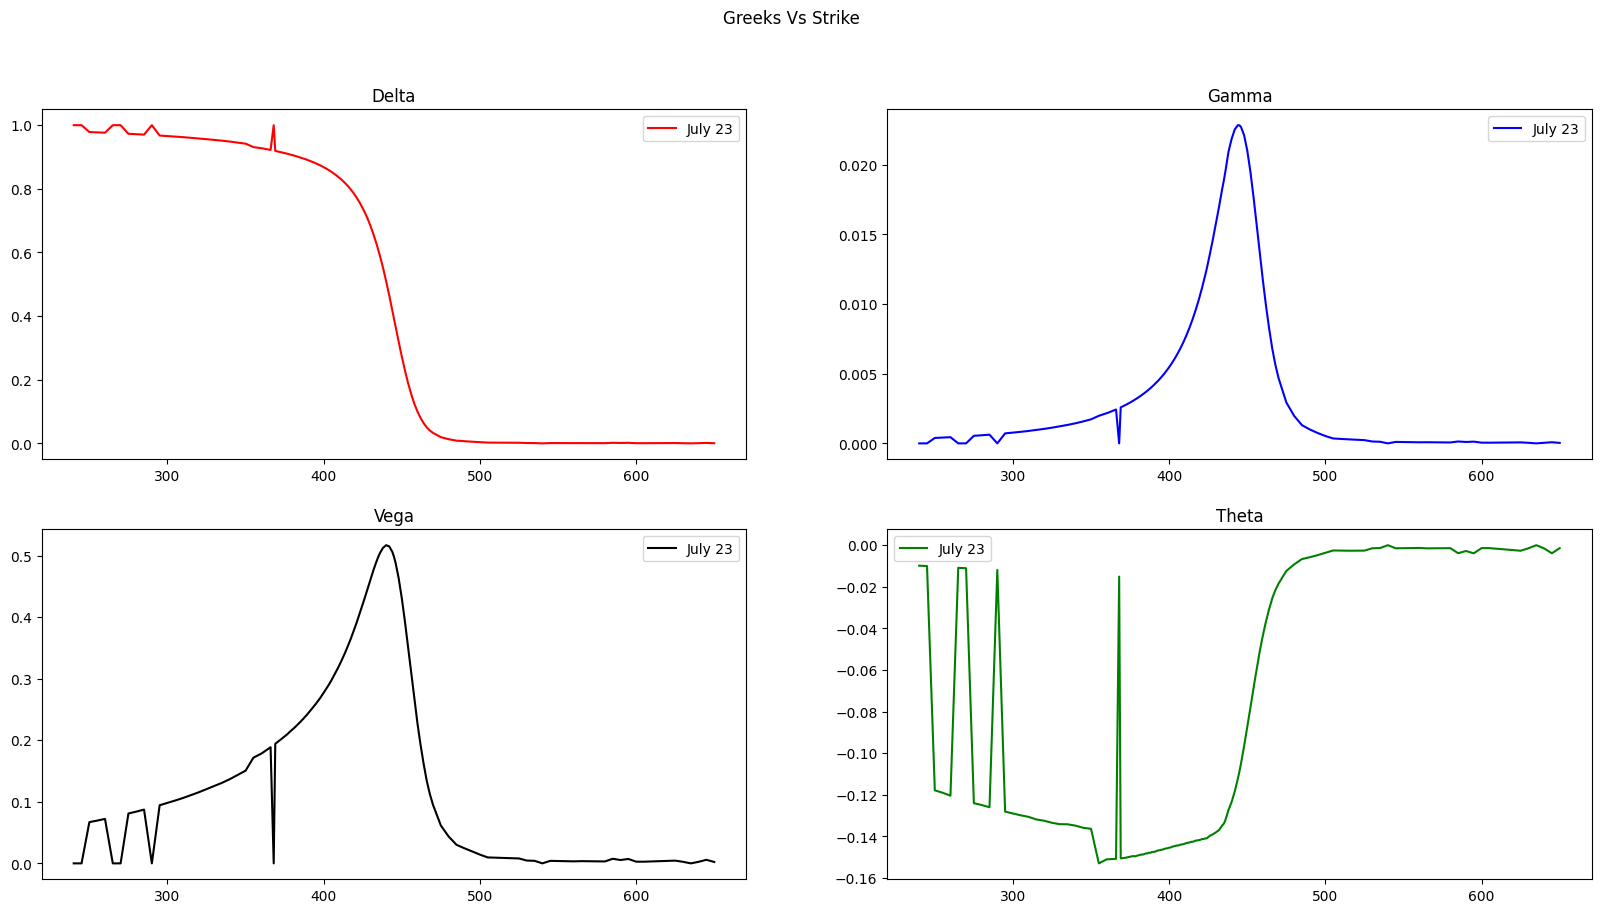

In [49]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='July 23')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='July 23')
ax[1,0].plot(df['Strike'], df['Vega'], color='k', label='July 23')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='July 23')
    
# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

# Set title
fig.suptitle('Greeks Vs Strike')

plt.show()

In [ ]:
#Utility
        self._a_ = self.volatility * self.dte ** 0.5
        
        if self.strike == 0:
            raise ZeroDivisonError('The strike price cannot be zero')
            
        else:
            self._d1_ = (log(self.spot / self.strike) + \
                        (self.rate+(self.volatility**2) / 2) * self.dte) / self._a_
        self._d2_ = self._d1_ - self._a_

In [ ]:
if self.strike == 0:
            raise ZeroDivisonError('The strike price cannot be zero')

In [82]:
#implied volatility code 
def implied_vol(market_price,
               strike, 
                spot,
               expiry, 
               interest_rate, 
               error):
    volatility = 0.2 #initial guess
    dv = error + 1
    while abs(dv) > error: 
        d1 = (log(spot / strike) + \
             (interest_rate + (volatility ** 2) /2) * expiry) / (volatility * expiry ** 0.5)
        d2 = d1 - (volatility * expiry ** 0.5)
        theoretical_option = BS(spot, strike, volatility, expiry, interest_rate)
        price_error = theoretical_option.callPrice - market_price
        dv = price_error / spot * sqrt(expiry) * norm.pdf(d1)
        volatility = volatility - dv
    return volatility
        

In [83]:
implied_vol(7.27,
           440,
           439.46, 
           0.0849, 
           0.05, 0.0000001)


0.19841052586549626